# CWNANO tutorial

- CWNANO (CW1101) datasheet : https://www.mouser.kr/datasheet/2/894/NAE-CW1101_datasheet-1601394.pdf
- Chipwhisperer docs : https://chipwhisperer.readthedocs.io/en/latest/


## 0. check version and update
do it if you need

In [1]:
import chipwhisperer as cw
print(cw.__version__)
# !pip install chipwhisperer --upgrade

try:
    import chipwhisperer as cw
    scope = cw.scope()
    if scope.latest_fw_str > scope.fw_version_str:
        scope.upgrade_firmware()
    else:
        print("lastest version installed")
    scope.dis()
except:
    print("Failed")
    pass

import chipwhisperer as cw
scope = cw.scope()
scope.dis()
print(scope.fw_version)

5.6.1
lastest version installed
{'major': 0, 'minor': 62, 'debug': 0}


## 1. set up

In [2]:
SCOPETYPE = 'CWNANO'
PLATFORM = 'CWNANO'
CRYPTO_TARGET = 'TINYAES128C' # 'TINYAES128C' 
SS_VER = 'SS_VER_1_1'
PATH = '../hardware/victims/firmware/simpleserial-aes'

In [3]:
# %run "Setup_Scripts/Setup_Generic.ipynb"
import time

try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope() # cw.scope(type=cw.scopes.CWNano)

try:
    if SS_VER == "SS_VER_2_1":
        target_type = cw.targets.SimpleSerial2
    elif SS_VER == "SS_VER_2_0":
        raise OSError("SS_VER_2_0 is deprecated. Use SS_VER_2_1")
    else:
        target_type = cw.targets.SimpleSerial
except:
    SS_VER="SS_VER_1_1"
    target_type = cw.targets.SimpleSerial

try:
    target = cw.target(scope, target_type)
except:
    print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
    print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
    scope = cw.scope()
    target = cw.target(scope, target_type)

print("INFO: Found ChipWhisperer")

# set programmer
if "STM" in PLATFORM or PLATFORM == "CWLITEARM" or PLATFORM == "CWNANO":
    prog = cw.programmers.STM32FProgrammer
elif PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
    prog = cw.programmers.XMEGAProgrammer
elif "neorv32" in PLATFORM.lower():
    prog = cw.programmers.NEORV32Programmer
else:
    prog = None
    
# wait and setup
time.sleep(0.05)
scope.default_setup()

INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.
INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.
INFO: Found ChipWhisperer


## 2. check Chipwhisperer options

In [4]:
scope.adc.clk_freq = 7.5e6 # 3.75e6, 7.5e6, 15e6, 30e6, 60e6; refer the datasheet
# scope.adc.clk_src = 'ext' # 'int' or 'ext'
# scope.io.clkout = 

scope.adc.samples = 10000 # buffer size: 50000, but it doesn't mean the number is maximum

print(scope.adc.samples, scope.adc.clk_freq)
print(scope.dev)

10000 7500000.0
ChipWhisperer Nano Device
fw_version = 
    major = 0
    minor = 62
    debug = 0
io = 
    tio1         = None
    tio2         = None
    tio3         = None
    tio4         = high_z
    pdid         = True
    pdic         = False
    nrst         = True
    clkout       = 7500000.0
    cdc_settings = bytearray(b'\x01\x00\x00\x00')
adc        = <class 'dict'>
glitch     = <class 'dict'>



### 3. Build and Program
basic source code
```
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER" "$PATH"
cd $4
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3
```

In [5]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER" "$PATH"
cd $4
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3

Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
make clean_objs .dep 
make[1]: Entering directory '/home/vagrant/work/projects/chipwhisperer/hardware/victims/firmware/simpleserial-aes'
Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWNANO.hex
rm -f -- simpleserial-aes-CWNANO.eep
rm -f -- simpleserial-aes-CWNANO.cof
rm -f -- simpleserial-aes-CWNANO.elf
rm -f -- simpleserial-aes-CWNANO.map
rm -f -- simpleserial-aes-CWNANO.sym
rm -f -- simpleserial-aes-CWNANO.lss
rm -f -- objdir-CWNANO/*.o
rm -f -- objdir-CWNANO/*.lst
rm -f -- simpleserial-aes.s simpleserial.s stm32f0_hal_nano.s stm32f0_hal_lowlevel.s aes.s aes-independant.s
rm -f -- simpleserial-aes.d simpleserial.d stm32f0_hal_nano.d stm32f0_hal_lowlevel.d aes.d aes-independant.d
rm -f -- simpleserial-aes.i simpleserial.i stm32f0_hal_nano.i stm32f0_hal_lo

In [6]:
cw.program_target(scope, prog, PATH+"/"+(PATH[-PATH[::-1].find("/"):])+"-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F03xx4/03xx6
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6219 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6219 bytes


### 3-1. set moving figure

In [7]:
import holoviews as hv
from holoviews.streams import Pipe, Buffer
import pandas as pd
class real_time_plot:
    def __init__(self, plot_len):
        hv.extension('bokeh')
        st = pd.DataFrame({'power_consumption':[]}, columns=['power_consumption'])
        self.dfstream = Buffer(st, length=plot_len, index=False)
        curve_dmap = hv.DynamicMap(hv.Curve, streams=[self.dfstream])
        curve_dmap.opts(width=900, height=300)
        display(curve_dmap)
    def send(self, data):
        if hasattr(data, 'wave'):
            d = data.wave
        else:
            d = data
        self.dfstream.send(pd.DataFrame({'power_consumption':d}))

### 3-2. funtions

In [8]:
def str2bytesarr(string):
    bytesarr = [int(string[i:i+2], base=16) for i in range(0, len(string), 2)]
        
    return bytesarr

## 4. Capture the power!

In [9]:
from tqdm.notebook import trange
import numpy as np
import time

ktp = cw.ktp.Basic()

# proj = cw.create_project("cwnano_basic", overwrite=True)
waveset = []
textin_array = []
keyin_array = []

N = 1000

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
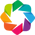

:DynamicMap   []
   :Curve   [index]   (power_consumption)

In [10]:
plot = real_time_plot(plot_len=scope.adc.samples)

In [11]:
for i in trange(N, desc='Capturing traces'):
    key, text = ktp.next()
    trace = cw.capture_trace(scope, target, text, key)
    if not trace:
        continue
    
    # proj.traces.append(trace)
    plot.send(trace)
    waveset.append(trace[0])
    textin_array.append(str2bytesarr(text.hex()))
    keyin_array.append(str2bytesarr(key.hex()))
    
# proj.save()

Capturing traces:   0%|          | 0/1000 [00:00<?, ?it/s]

### 4-1. close the connection
if you want

In [12]:
# scope.dis()
# target.dis()

## 5. analysis the collected traces

In [13]:
import matplotlib.pyplot as plt
plt.show()
plt.rcParams["figure.figsize"] = (17,5)
plt.rcParams['figure.dpi'] = 200 

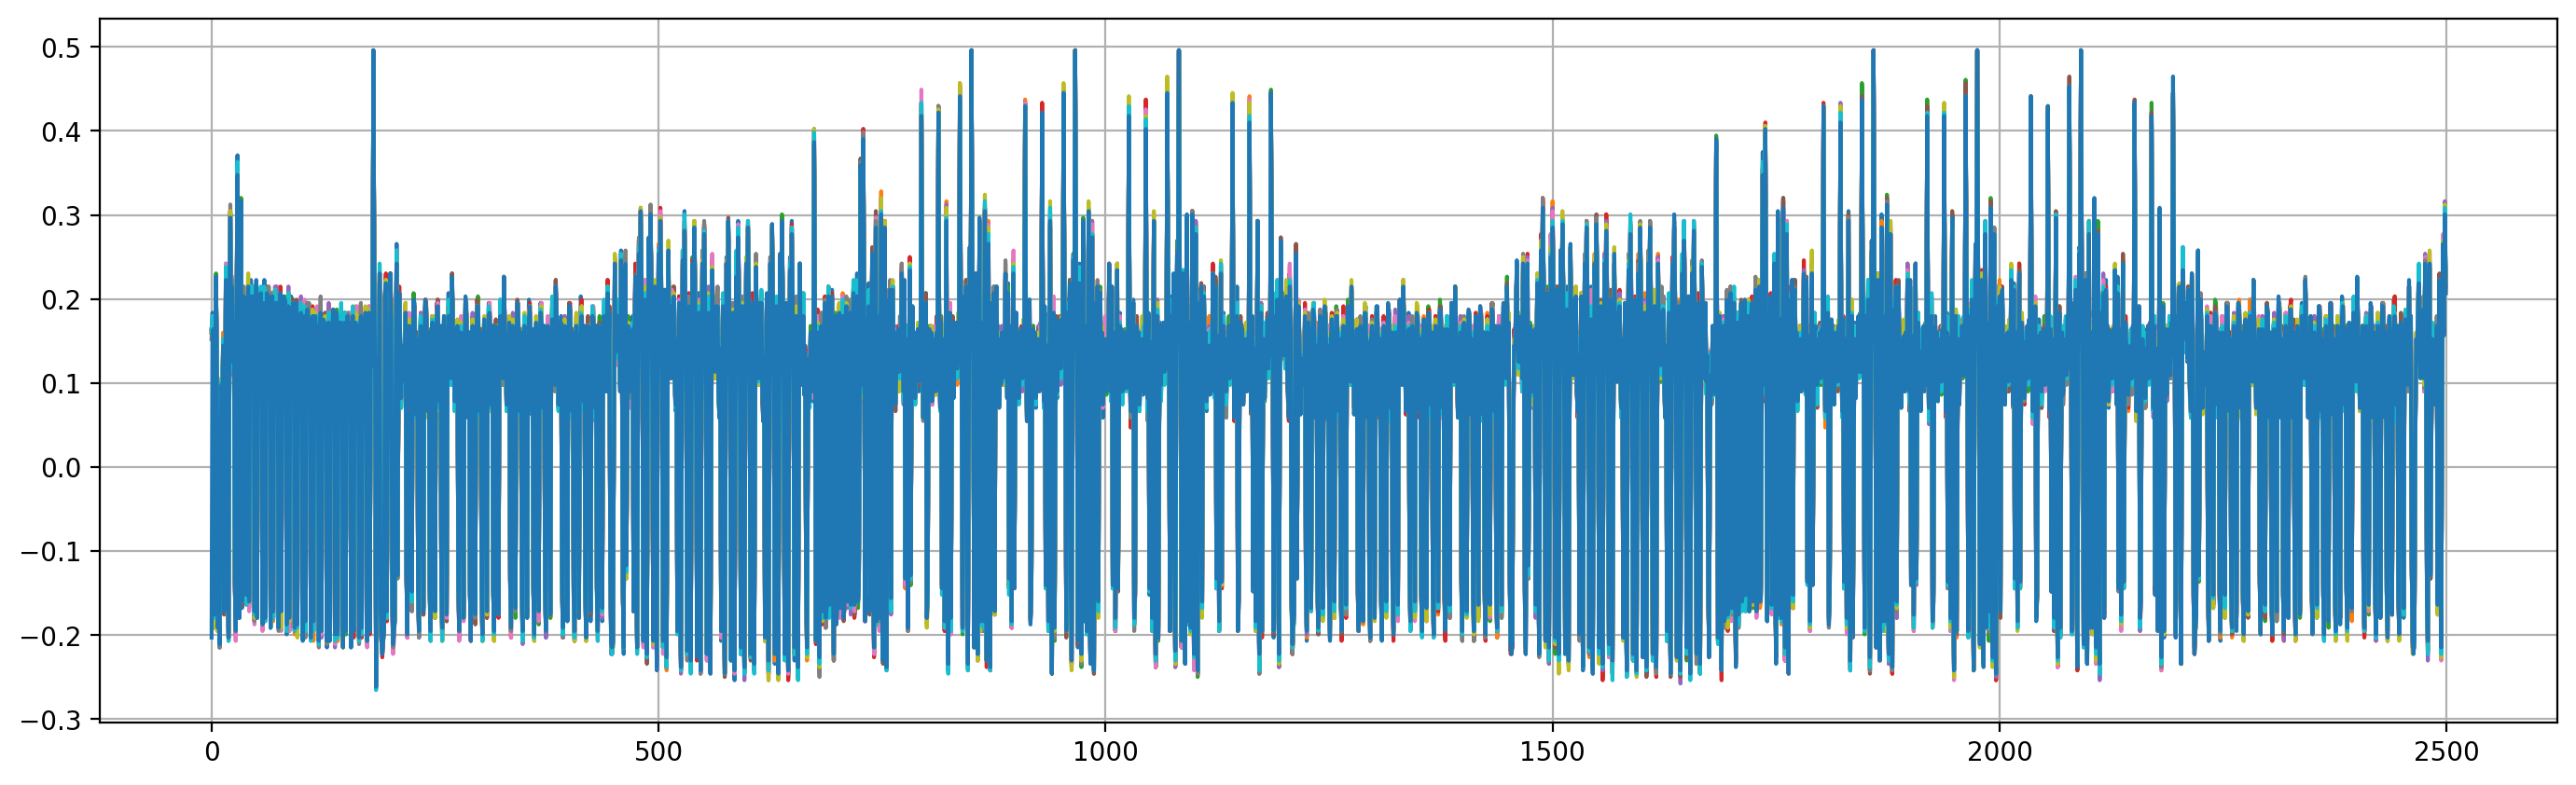

In [14]:
for i in range((len(waveset)//100)+1):
    plt.plot(waveset[i][:2500])
plt.grid()
plt.show()

In [15]:
trace = np.array(waveset)
pt = np.array(textin_array)
key = keyin_array[0]

### 5-1. functions for CPA

In [16]:
aes_sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16 ])

def hypohw(pt, sbox, keysize=256):
    hypo = []
    for k in range(keysize):
        hypo.append([bin(sbox[np.int32(p) ^ k]).count('1') for p in pt])
    
    return np.array(hypo)

def corr(A, B):
    if len(A) != len(B):
        raise(ValueError, "operands could not be broadcast together")
    
    def _init(A, B):
        a = np.array(A, dtype=np.float64)
        b = np.array(B, dtype=np.float64)        
        
        try :
            return matlab_like_corr(a, b)
        except:
            return np.corrcoef(a, b)[0, 1] # Error
        
    def matlab_like_corr(A, B): 
        np.seterr(divide='ignore', invalid='ignore')
        
        DA = A -  np.mean(A, axis=0)
        DB = B -  np.mean(B, axis=0)
        
        CV = np.dot(DA.T, DB) / np.double(len(A))
    
        VA = np.mean(np.square(DA), axis=0)[:, np.newaxis]
        VB = np.mean(np.square(DB), axis=0)[np.newaxis, :]
    
        return (CV / np.sqrt(np.dot(VA, VB)))
    
    ret = _init(A, B)
    ret[np.isnan(ret)] = 0
    
    return ret

### 5-2. CPA

In [17]:
ret_cpa = []
guess_key = []

for i in trange(16, desc='recovering a sub-key by CPA'):
    hypo_hw = hypohw(pt[:, i], aes_sbox, 256)
    ret_corr = corr(trace, hypo_hw.T)

    ret_cpa.append(ret_corr)
    guess_key.append(np.argmax(np.sum(ret_corr==np.max(ret_corr), axis=0)))

recovering a sub-key by CPA:   0%|          | 0/16 [00:00<?, ?it/s]

### 5-3. CPA results

In [18]:
print(key)
print(guess_key)

[43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60]
[43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60]


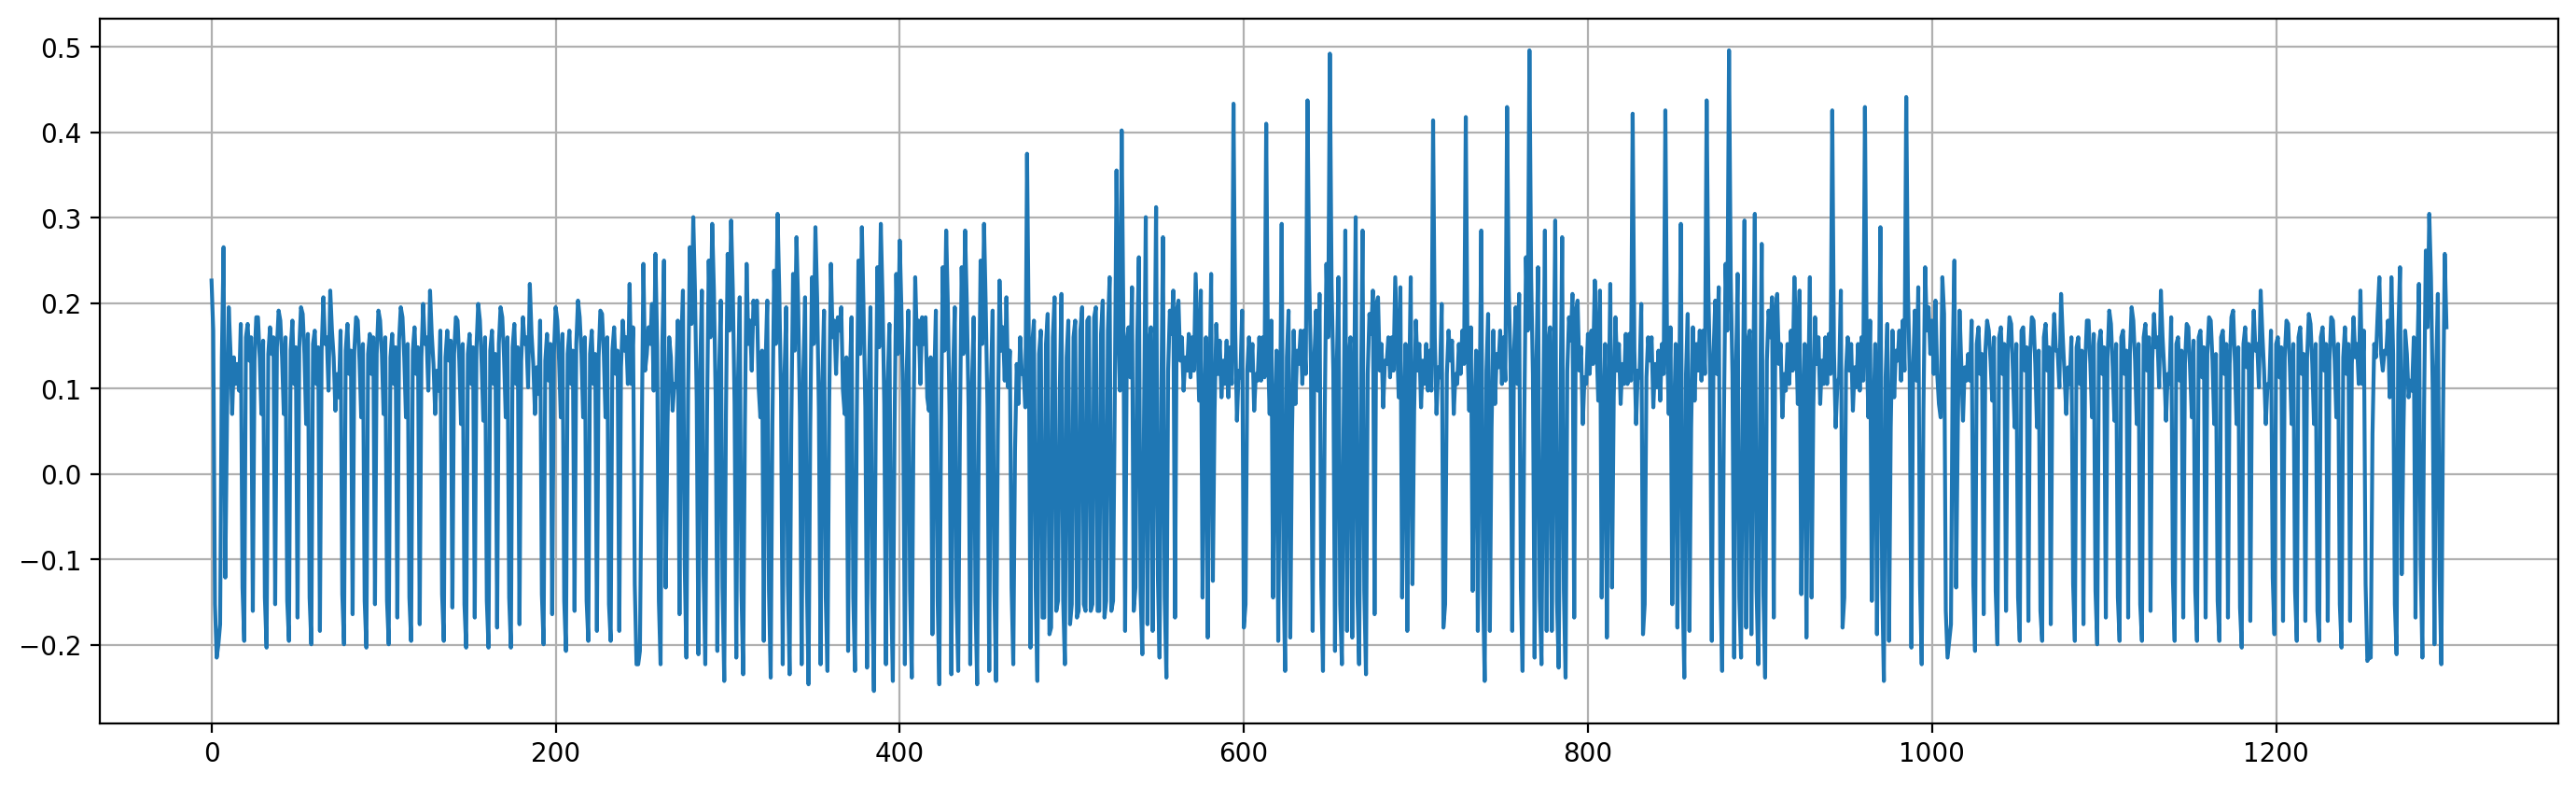

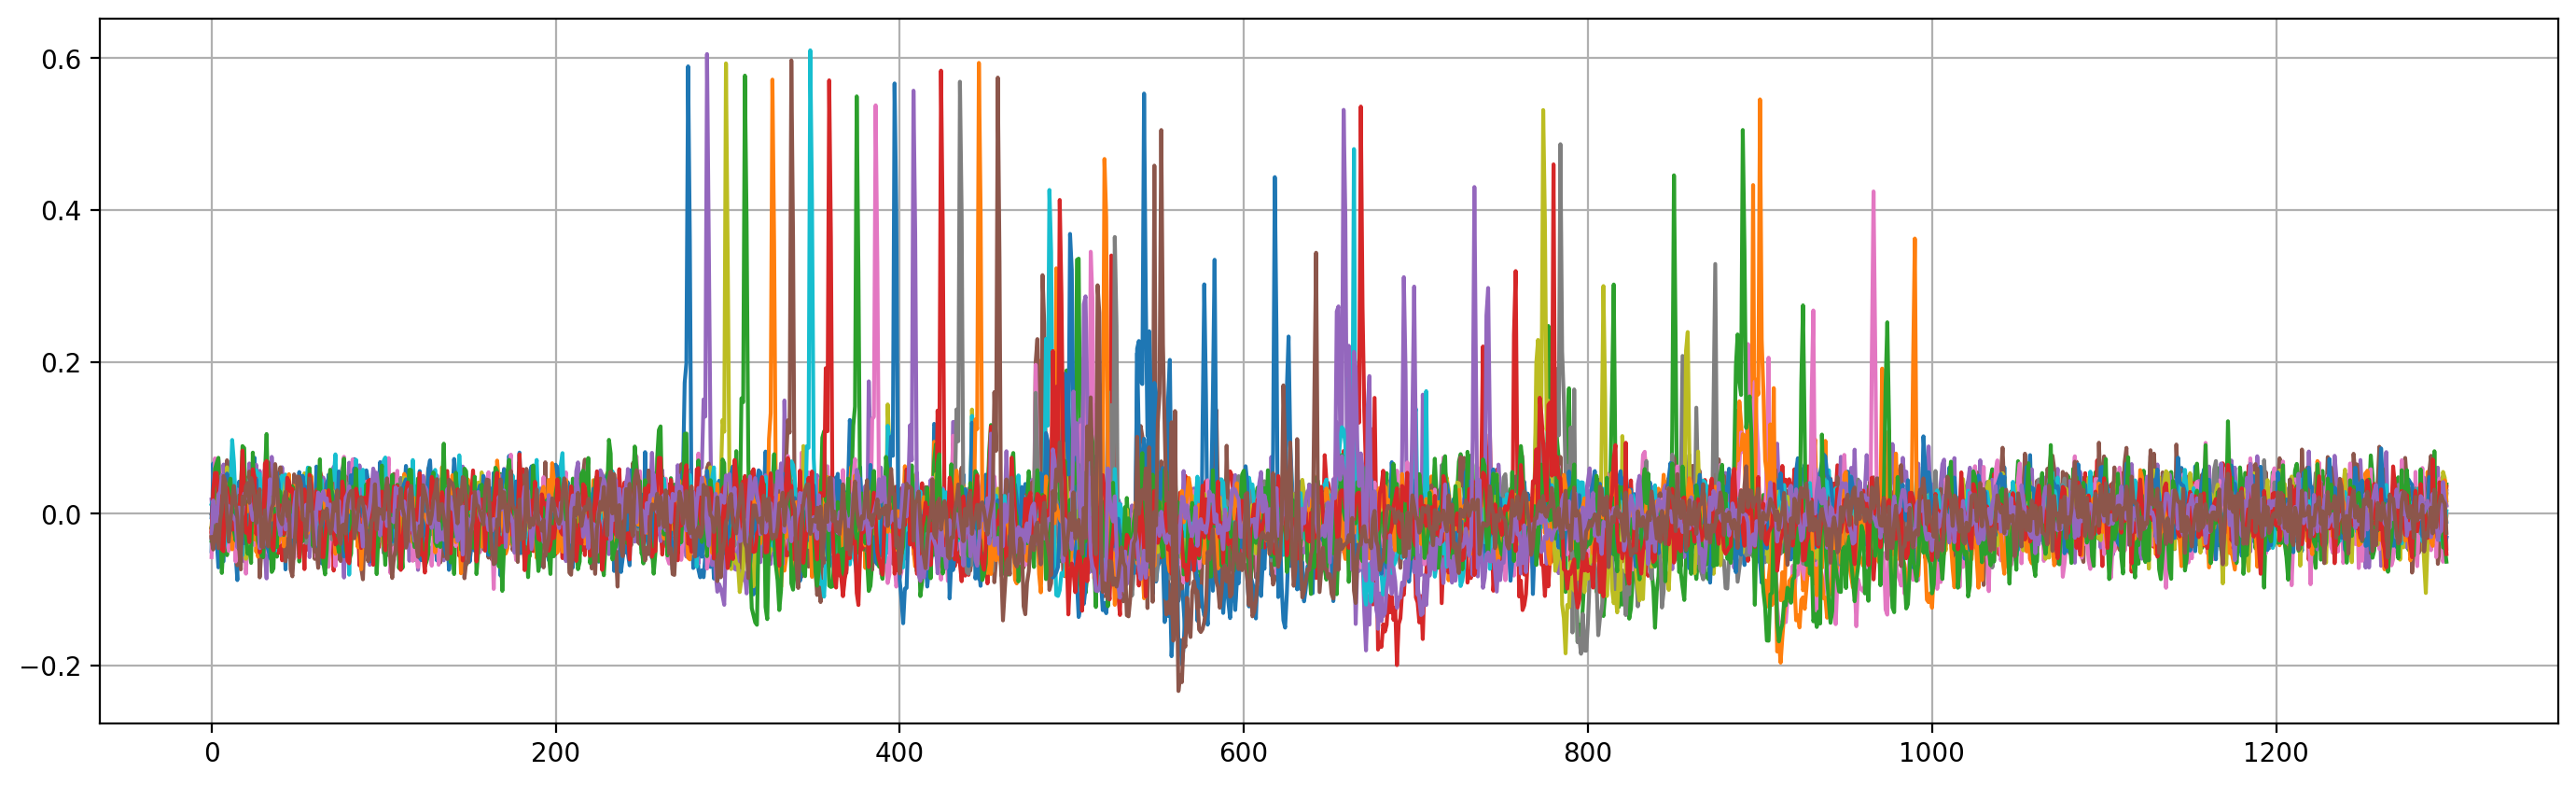

In [19]:
plt.plot(trace[0, 200:1500])
plt.grid()
plt.show()

for i in range(16):
    plt.plot(ret_cpa[i][200:1500, guess_key[i]])
plt.grid()
plt.show()